## ECS7013P Coursework
Music Genre classification and Music Feature estimation

In [2]:
import csv
from itertools import islice
from pathlib import Path
import random
import os
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torch.utils.data import TensorDataset, DataLoader
import torchaudio
import torchaudio.functional as taF
import librosa
from torch.utils.data import SubsetRandomSampler
import pandas as pd

import IPython.display as ipd
import matplotlib.pyplot as plt

# use GPU if available, otherwise, use cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Prepare Dataset

In [3]:
csv_file = 'features_3_sec.csv'
df = pd.read_csv(csv_file)
count = {
    'blues': 0,
    'classical': 0,
    'country': 0,
    'disco': 0,
    'hiphop': 0,
    'jazz': 0,
    'metal': 0,
    'pop': 0,
    'reggae': 0,
    'rock': 0
}
genres = {
    'blues': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'classical': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    'country': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    'disco': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    'hiphop': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    'jazz': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    'metal': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    'pop': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    'reggae': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    'rock': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
}

# process the csv file and choose labels for each file
number_of_entries = 0
file_labels = {}
for index, row in df.iterrows():
    file_id_parts = row['filename'].split('.')
    if file_id_parts[2] == '0':
        number_of_entries += 1
    file_path = f"./Genres/{file_id_parts[0]}/{file_id_parts[0]}.{file_id_parts[1]}.{file_id_parts[3]}"
    label = [
        genres[row['label']], 
        row['chroma_stft_mean'], 
        row['chroma_stft_var'], 
        row['harmony_mean'], 
        row['harmony_var'], 
        row['tempo']
    ]
    if not file_path in file_labels:
        file_labels[file_path] = [[],[],[],[],[],[],[],[],[],[]]
    file_labels[file_path][int(file_id_parts[2])] = label


def addkey(key):
    count[key] = count[key] + 1
    

counter = 0
keys_to_remove = []
for key, value in file_labels.items():
    #display(ipd.Audio(key))
    #print(key,value)
    if not os.path.isfile(key) or [] in value:
        keys_to_remove.append(key)
    else:
        addkey(key.split('/')[2])

print(len(keys_to_remove))
for k in keys_to_remove:
    number_of_entries -= 1
    del file_labels[k]

print(f"Number of entries: {number_of_entries}")
for key,value in count.items():
    print(key,value)

11
Number of entries: 989
blues 100
classical 98
country 97
disco 99
hiphop 98
jazz 99
metal 100
pop 100
reggae 100
rock 98


In [4]:
def extract_melspectrograms(audio_path, sample_rate=22050, win_duration=0.05, hop_duration=0.025, n_mels=64, segment_duration=3):
    # method for extracting mel spectrograms of length t from an audio file 
    segment_len = int(segment_duration * sample_rate)
    audio, original_rate = torchaudio.load(audio_path)
    num_segments = audio.size(1) // segment_len
    melspecgrams = []
    # extract specrogram for each segment
    for i in range(num_segments):
        start_idx = i * segment_len
        end_idx = start_idx + segment_len
        segment_audio = audio[:, start_idx:end_idx]
        
        melspecgram = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate, n_fft=2048, win_length=round(win_duration * sample_rate),
            hop_length=round(hop_duration * sample_rate), n_mels=n_mels)(segment_audio).squeeze()
        
        melspecgrams.append(melspecgram)
    
    return melspecgrams

num_frames = 119
n_mels = 64
segment_duration = 3

# initialize tensors to store data, labels
data = torch.zeros((number_of_entries * 10, num_frames, n_mels))  # for storing mel spectrograms of 3s long segments
labels = torch.zeros(number_of_entries * 10, 10)  # for storing labels of data
labels_features = torch.zeros(number_of_entries * 10, 5)

# iterate through each song path
counter = 0;
for (path, labels_d) in file_labels.items():  
    # Extract Mel spectrograms for segments
    try:
        melspecgrams = extract_melspectrograms(path, n_mels=n_mels, segment_duration=segment_duration)
        for k, melspecgram in enumerate(melspecgrams):
            if melspecgram.shape[1] < num_frames:
                melspecgram = nnF.pad(melspecgram, (0, num_frames - melspecgram.shape[1]))
            elif melspecgram.shape[1] > num_frames:
                melspecgram = melspecgram[:, :num_frames]
            
            data[counter] = melspecgram.T[:num_frames]  # truncate if necessary
            labels[counter] = torch.tensor(labels_d[k][0], dtype=torch.float)
            labels_features[counter] = torch.tensor(labels_d[k][1:], dtype=torch.float)
            counter += 1
            if counter % 100 == 0:   
                print(f"{counter} songs finished")
        
    except Exception as e:
        print(path)
        print(labels_d)
        

# convert data,labels to tensors
data = torch.tensor(data)
labels = torch.tensor(labels, dtype=torch.float)
labels_features = torch.tensor(labels_features, dtype=torch.float)


100 songs finished
200 songs finished
300 songs finished
400 songs finished
500 songs finished
600 songs finished
700 songs finished
800 songs finished
900 songs finished
1000 songs finished
1100 songs finished
1200 songs finished
1300 songs finished
1400 songs finished
1500 songs finished
1600 songs finished
1700 songs finished
1800 songs finished
1900 songs finished
2000 songs finished
2100 songs finished
2200 songs finished
2300 songs finished
2400 songs finished
2500 songs finished
2600 songs finished
2700 songs finished
2800 songs finished
2900 songs finished
3000 songs finished
3100 songs finished
3200 songs finished
3300 songs finished
3400 songs finished
3500 songs finished
3600 songs finished
3700 songs finished
3800 songs finished
3900 songs finished
4000 songs finished
4100 songs finished
4200 songs finished
4300 songs finished
4400 songs finished
4500 songs finished
4600 songs finished
4700 songs finished
4800 songs finished
4900 songs finished
5000 songs finished
5100 song

/tmp/ipykernel_94/4046970020.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data)
/tmp/ipykernel_94/4046970020.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float)
/tmp/ipykernel_94/4046970020.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_features = torch.tensor(labels_features, dtype=torch.float)


In [6]:
dataset = TensorDataset(data, labels)
shuffled_indices = torch.randperm(len(dataset))

# ratio of split
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

num_samples = len(dataset)
num_train_samples = int(train_ratio * num_samples)
num_validation_samples = int(validation_ratio * num_samples)
num_test_samples = num_samples - num_train_samples - num_validation_samples

train_indices = shuffled_indices[:num_train_samples]
validation_indices = shuffled_indices[num_train_samples:num_train_samples + num_validation_samples]
test_indices = shuffled_indices[num_train_samples + num_validation_samples:]

# create separate datasets for train, validation, and test sets
train_dataset = TensorDataset(data[train_indices], labels[train_indices])
validation_dataset = TensorDataset(data[validation_indices], labels[validation_indices])
test_dataset = TensorDataset(data[test_indices], labels[test_indices])

train_dataset2 = TensorDataset(data[train_indices], labels_features[train_indices])
validation_dataset2 = TensorDataset(data[validation_indices], labels_features[validation_indices])
test_dataset2 = TensorDataset(data[test_indices], labels_features[test_indices])

batch_size = 20

# create DataLoader objects for train, validation, and test sets for both tasks
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
validation_loader2 = DataLoader(validation_dataset2, batch_size=batch_size, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)


data entries shape: torch.Size([9890, 119, 64])
one datapoint shape: torch.Size([119, 64])
label example: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


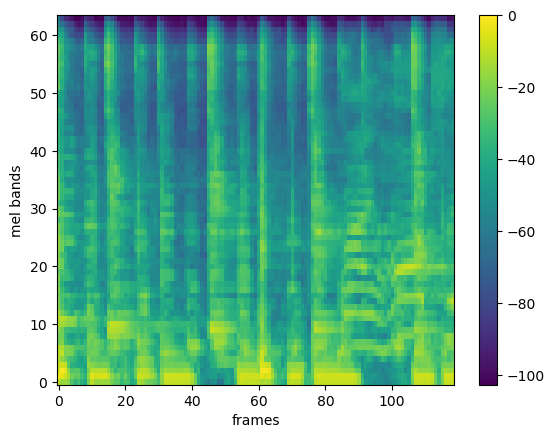

In [7]:
# show sample spectrogram
print(f"data entries shape: {data.shape}")
print(f"one datapoint shape: {data[0].shape}")
print(f"label example: {labels[0]}")
example = data[8002]
dB_spec = taF.amplitude_to_DB(example, multiplier=10, amin=1e-8, db_multiplier=example.max().log10()).T
fig, ax = plt.subplots()
img = ax.imshow(dB_spec, aspect='auto', origin='lower')
fig.colorbar(img)
ax.set_xlabel('frames')
ax.set_ylabel('mel bands');

## Define Genre Classification Model

In [8]:
class GenreClassificationModel(nn.Module):
    # Convolutional network for predicting genre classes

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(5, 5), bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.act = nn.ReLU()
        self.mp1 = nn.MaxPool2d(kernel_size=(5, 4), padding=(2, 0))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=128)
        self.mp2 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.mp3 = nn.MaxPool2d(kernel_size=(4, 5), padding=(0, 0))
        self.fc1 = nn.Linear(in_features=128*2*1, out_features=128, bias=True)
        self.fc2 = nn.Linear(in_features=128, out_features=10, bias=True)
        self.final_act = nn.Softmax()

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.BatchNorm2d):
            torch.nn.init.ones_(module.weight)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.act(self.bn1(self.conv1(x)))
        x = self.mp1(x)
        x = self.act(self.bn2(self.conv2(x)))
        x = self.mp2(x)
        x = self.act(self.bn3(self.conv3(x)))
        x = self.mp3(x)
        x = x.view(len(x), -1)
        x = self.act(self.fc1(x))
        x = self.final_act(self.fc2(x))
        return x    

In [16]:
# create a basic model instance
model = GenreClassificationModel().to(device)
print(model)

criterion = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.)

GenreClassificationModel(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (mp1): MaxPool2d(kernel_size=(5, 4), stride=(5, 4), padding=(2, 0), dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp3): MaxPool2d(kernel_size=(4, 5), stride=(4, 5), padding=(0, 0), dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (final_act): Softmax(dim=None)
)


In [10]:
def evaluate(model, data_loader, criterion):
    model.eval()
    num_batches = len(data_loader)
    epoch_loss = 0.
    accuracy = 0.
    with torch.no_grad():
        for batch_inputs, batch_labels in data_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)
            batch_outputs = model(batch_inputs)
            # Calculate loss using Cross Entropy Loss
            loss = criterion(batch_outputs, batch_labels)
            epoch_loss += loss.item()
            # Convert output probabilities to predicted labels
            _, predicted_labels = torch.max(batch_outputs, dim=1)
            _, batch_labels_indices = torch.max(batch_labels, dim=1)
            # Compare predicted labels with true labels
            correct_predictions = (predicted_labels == batch_labels_indices).sum().item()
            
            # Update accuracy
            accuracy += correct_predictions

    epoch_loss /= num_batches
    accuracy /= len(data_loader.dataset)
    return epoch_loss, accuracy

In [11]:
def train(model, train_loader, valid_loader, criterion, optimizer, num_epochs, saved_model, evaluate_every_n_epochs=1):
    model.train()
    num_batches = len(train_loader)
    best_valid_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_accuracies = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_inputs, batch_labels in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_inputs).squeeze(dim=1)
            loss = criterion(outputs, batch_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # accumulate loss
            epoch_loss += loss.item()

        epoch_loss /= num_batches
        print(f'[{epoch+1}] loss: {epoch_loss:.6f}')
        train_losses.append(epoch_loss)
        
        if((epoch+1) % evaluate_every_n_epochs == 0):
            valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
            print(f'Validation loss: {valid_loss:.6f}')
            print(f'Validation accuracy: {100*valid_acc:.2f}%')
            valid_losses.append(valid_loss)
            valid_accuracies.append(valid_acc)
            model.train()
            
            if(valid_acc >= best_valid_acc):
                best_valid_acc = valid_acc
                print('Saving best model')
                torch.save(model.state_dict(), saved_model)
    return train_losses, valid_losses, valid_accuracies

In [17]:
num_epochs = 200 
saved_model = './best_model_basic.pkl' 
evaluate_every_n_epochs = 2  
train_losses, valid_losses, valid_accuracies = train(model, train_loader, validation_loader, criterion, optimizer, num_epochs, saved_model, evaluate_every_n_epochs)

[1] loss: 2.283673
[2] loss: 2.242135
Validation loss: 2.222590
Validation accuracy: 28.31%
Saving best model
[3] loss: 2.217713
[4] loss: 2.199367
Validation loss: 2.184169
Validation accuracy: 31.04%
Saving best model
[5] loss: 2.180551
[6] loss: 2.167059
Validation loss: 2.160600
Validation accuracy: 32.56%
Saving best model
[7] loss: 2.155787
[8] loss: 2.146548
Validation loss: 2.140189
Validation accuracy: 33.37%
Saving best model
[9] loss: 2.138388
[10] loss: 2.132992
Validation loss: 2.127302
Validation accuracy: 33.87%
Saving best model
[11] loss: 2.125503
[12] loss: 2.120086
Validation loss: 2.118445
Validation accuracy: 34.98%
Saving best model
[13] loss: 2.116999
[14] loss: 2.109595
Validation loss: 2.109911
Validation accuracy: 35.39%
Saving best model
[15] loss: 2.103119
[16] loss: 2.100715
Validation loss: 2.108829
Validation accuracy: 34.78%
[17] loss: 2.095525
[18] loss: 2.090211
Validation loss: 2.104626
Validation accuracy: 35.89%
Saving best model
[19] loss: 2.086460

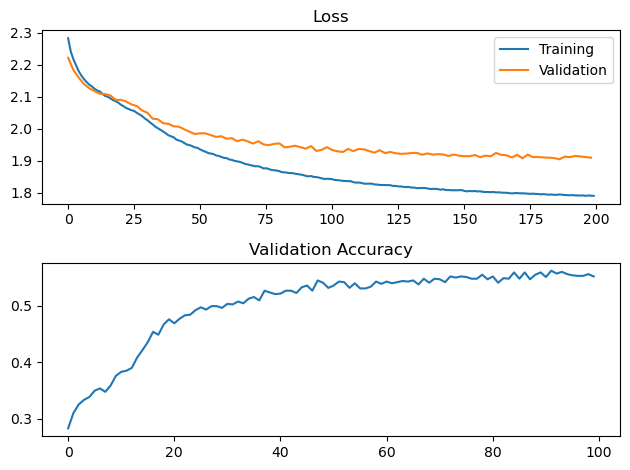

In [18]:
import numpy as np

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(train_losses, label='Training')
ax1.plot(np.arange(0, len(valid_losses)*2, 2), valid_losses, label='Validation')  # plotting every other epoch
ax1.legend()
ax1.set_title('Loss')

ax2.plot(valid_accuracies)
ax2.set_title('Validation Accuracy')
plt.tight_layout()

In [19]:
model = GenreClassificationModel().to(device)
model.load_state_dict(torch.load(saved_model))

# evaluate on the test data
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test loss: {test_loss:.6f}')
print(f'Test accuracy: {100*test_acc:.2f}%')

Test loss: 1.892536
Test accuracy: 57.43%


## Feature Estimation Model

A convolutional-recurrent architecture

In [20]:
class FeatureEstimationModel(nn.Module):
    # Convolutional Recurrent network for feature Estimation

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.act = nn.ReLU()
        self.mp1 = nn.MaxPool2d(kernel_size=(4, 2), padding=(1, 0))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=128)
        self.mp2 = nn.MaxPool2d(kernel_size=(3, 3), padding=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.mp3 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 1))
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), bias=False)
        self.bn4 = nn.BatchNorm2d(num_features=128)
        self.mp4 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 1))
        #self.mp3 = nn.MaxPool2d(kernel_size=(5, 5), padding=(0, 0))
        self.rnl1 = nn.GRU(input_size = 512, hidden_size = 64, num_layers = 1)
        self.rnl2 = nn.GRU(input_size = 64, hidden_size = 64, num_layers = 1)
        #self.fc1 = nn.Linear(in_features=128*2*1, out_features=128, bias=True)
        self.fc1 = nn.Linear(in_features=64, out_features=128, bias=True)
        self.fc2 = nn.Linear(in_features=128, out_features=5, bias=True)
        self.final_act = nn.ELU()

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.BatchNorm2d):
            torch.nn.init.ones_(module.weight)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.act(self.bn1(self.conv1(x)))
        x = self.mp1(x)
        x = self.act(self.bn2(self.conv2(x)))
        x = self.mp2(x)
        x = self.act(self.bn3(self.conv3(x)))
        x = self.mp3(x)
        x = self.act(self.bn4(self.conv4(x)))
        x = self.mp4(x)
        x = x.view(len(x), -1)
        x = x.unsqueeze(0)  
        x, _ = self.rnl1(x) 
        x, _ = self.rnl2(x)  
        x = x[-1]
        x = self.act(self.fc1(x))
        x = self.final_act(self.fc2(x))   
        return x

In [21]:
model2 = FeatureEstimationModel().to(device)
print(model2)

criterion2 = nn.MSELoss()

optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.)

FeatureEstimationModel(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (mp1): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=(1, 0), dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp2): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp4):

In [22]:
def evaluate2(model, data_loader, criterion):
    model.eval()
    num_batches = len(data_loader)
    epoch_loss = 0.
    with torch.no_grad():
        for batch_inputs, batch_labels in data_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)
            # Forward pass
            batch_outputs = model(batch_inputs)
            loss = criterion(batch_outputs, batch_labels)
            epoch_loss += loss.item()

    epoch_loss /= num_batches
    return epoch_loss

In [23]:
def train2(model, train_loader, valid_loader, criterion, optimizer, num_epochs, saved_model, evaluate_every_n_epochs=1):
    model.train()
    num_batches = len(train_loader)
    best_valid_loss = 10000.
    train_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_inputs, batch_labels in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)
            outputs = model(batch_inputs).squeeze(dim=1)        
            loss = criterion(outputs, batch_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # accumulate loss
            epoch_loss += loss.item()

        epoch_loss /= num_batches
        # print training loss
        print(f'[{epoch+1}] loss: {epoch_loss:.6f}')
        train_losses.append(epoch_loss)
        
        # evaluate the network on the validation data
        if((epoch+1) % evaluate_every_n_epochs == 0):
            # TODO: What data is used here?
            valid_loss = evaluate2(model, valid_loader, criterion)
            print(f'Validation loss: {valid_loss:.6f}')
            valid_losses.append(valid_loss)
            model.train()
             
            if(valid_loss <= best_valid_loss):
                best_valid_loss = valid_loss
                print('Saving best model')
                torch.save(model.state_dict(), saved_model)
    return train_losses, valid_losses

In [24]:
num_epochs = 200 
saved_model2 = './best_model_feature.pk1' 
evaluate_every_n_epochs = 2 
train_losses2, valid_losses2 = train2(model2, train_loader2, validation_loader2, criterion2, optimizer2, num_epochs, saved_model2, evaluate_every_n_epochs)

[1] loss: 3307.453177
[2] loss: 3206.705047
Validation loss: 3120.085557
Saving best model
[3] loss: 3034.076261
[4] loss: 2835.364305
Validation loss: 2732.992305
Saving best model
[5] loss: 2656.719224
[6] loss: 2498.776768
Validation loss: 2416.678799
Saving best model
[7] loss: 2355.683283
[8] loss: 2221.664952
Validation loss: 2148.658335
Saving best model
[9] loss: 2092.691843
[10] loss: 1969.502299
Validation loss: 1902.494360
Saving best model
[11] loss: 1850.540139
[12] loss: 1734.397756
Validation loss: 1672.101943
Saving best model
[13] loss: 1622.320078
[14] loss: 1513.217320
Validation loss: 1455.093887
Saving best model
[15] loss: 1407.901030
[16] loss: 1306.600463
Validation loss: 1251.829421
Saving best model
[17] loss: 1207.798565
[18] loss: 1113.563376
Validation loss: 1063.043611
Saving best model
[19] loss: 1021.877854
[20] loss: 934.817233
Validation loss: 890.000234
Saving best model
[21] loss: 852.686760
[22] loss: 774.022908
Validation loss: 734.595997
Saving be

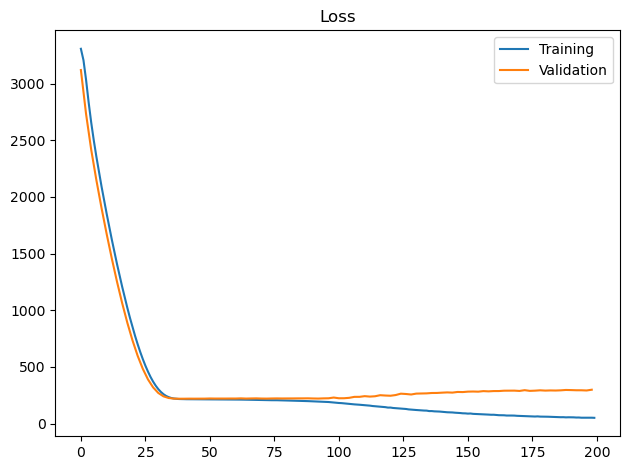

In [25]:
fig, ax1 = plt.subplots()
ax1.plot(train_losses2, label='Training')
ax1.plot(np.arange(0, len(valid_losses2)*2, 2), valid_losses2, label='Validation')
ax1.legend()
ax1.set_title('Loss')
plt.tight_layout()

In [26]:
model = FeatureEstimationModel().to(device)
model.load_state_dict(torch.load(saved_model2))

# evaluate on the test data
test_loss = evaluate2(model, test_loader2, criterion2)
print(f'Test loss: {test_loss:.6f}')

Test loss: 216.738708


## Genre Classification using Feature Estimation Model

In [27]:
f_model = FeatureEstimationModel().to(device)
f_model.load_state_dict(torch.load(saved_model2))


class GenreClassificationF(nn.Module):
    # Convolutional Recurrent network for predicting genre classes using feature estimation model

    def __init__(self, useFeatureEstimation=False):
        super().__init__()
        self.useFeatureEstimation = useFeatureEstimation
        in_f = 0
        if useFeatureEstimation:
            in_f = 69
        else:
            in_f = 64
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.act = nn.ReLU()
        self.mp1 = nn.MaxPool2d(kernel_size=(4, 2), padding=(1, 0))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=128)
        self.mp2 = nn.MaxPool2d(kernel_size=(3, 3), padding=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.mp3 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 1))
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), bias=False)
        self.bn4 = nn.BatchNorm2d(num_features=128)
        self.mp4 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 1))
        self.rnl1 = nn.GRU(input_size = 512, hidden_size = 64, num_layers = 1)
        self.rnl2 = nn.GRU(input_size = 64, hidden_size = 64, num_layers = 1)
        self.fc1 = nn.Linear(in_features=in_f, out_features=128, bias=True)
        self.fc2 = nn.Linear(in_features=128, out_features=10, bias=True)
        self.final_act = nn.Softmax()

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.BatchNorm2d):
            torch.nn.init.ones_(module.weight)

    def forward(self, x):
        features = f_model(x) if self.useFeatureEstimation else None
        x = x.unsqueeze(1)
        x = self.act(self.bn1(self.conv1(x)))
        x = self.mp1(x)
        x = self.act(self.bn2(self.conv2(x)))
        x = self.mp2(x)
        x = self.act(self.bn3(self.conv3(x)))
        x = self.mp3(x)
        x = self.act(self.bn4(self.conv4(x)))
        x = self.mp4(x)
        x = x.view(len(x), -1)
        x = x.unsqueeze(0)  
        x, _ = self.rnl1(x) 
        x, _ = self.rnl2(x)  
        x = x[-1]
        if self.useFeatureEstimation:
            x = torch.cat((x, features), dim=1)
        x = self.act(self.fc1(x))
        x = self.final_act(self.fc2(x))
        return x    

In [28]:
final_model = GenreClassificationF().to(device)
print(final_model)

criterion = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer = torch.optim.Adam(final_model.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.)

GenreClassificationF(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (mp1): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=(1, 0), dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp2): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp4): M

In [29]:
num_epochs = 200 
saved_model_f = './best_model_final.pkl'
evaluate_every_n_epochs = 1
train_losses_f, valid_losses_f, valid_accuracies_f = train(final_model, train_loader, validation_loader, criterion, optimizer, num_epochs, saved_model_f, evaluate_every_n_epochs)

[1] loss: 2.298460
Validation loss: 2.294126
Validation accuracy: 18.81%
Saving best model
[2] loss: 2.287034
Validation loss: 2.280559
Validation accuracy: 22.14%
Saving best model
[3] loss: 2.268663
Validation loss: 2.259646
Validation accuracy: 22.35%
Saving best model
[4] loss: 2.242937
Validation loss: 2.235081
Validation accuracy: 23.26%
Saving best model
[5] loss: 2.220972
Validation loss: 2.212921
Validation accuracy: 26.19%
Saving best model
[6] loss: 2.203007
Validation loss: 2.198046
Validation accuracy: 28.11%
Saving best model
[7] loss: 2.187684
Validation loss: 2.183756
Validation accuracy: 29.42%
Saving best model
[8] loss: 2.170885
Validation loss: 2.168041
Validation accuracy: 33.16%
Saving best model
[9] loss: 2.153203
Validation loss: 2.148852
Validation accuracy: 35.79%
Saving best model
[10] loss: 2.134963
Validation loss: 2.128680
Validation accuracy: 37.71%
Saving best model
[11] loss: 2.112965
Validation loss: 2.106456
Validation accuracy: 40.14%
Saving best mod

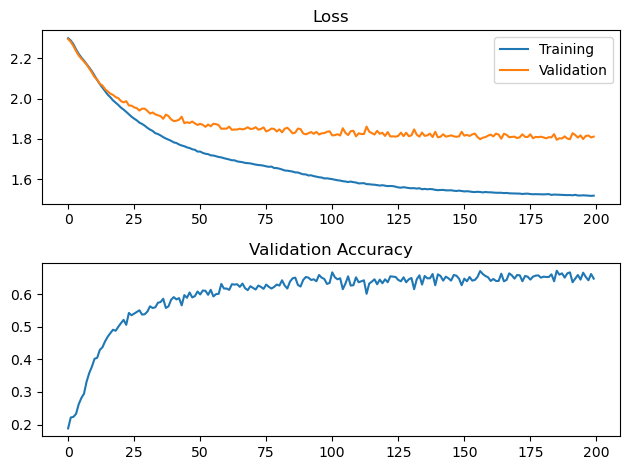

In [30]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(train_losses_f, label='Training')
ax1.plot(valid_losses_f, label='Validation')
ax1.legend()
ax1.set_title('Loss')
ax2.plot(valid_accuracies_f)
ax2.set_title('Validation Accuracy')
plt.tight_layout()

In [31]:
model_f = GenreClassificationF().to(device)
model_f.load_state_dict(torch.load(saved_model_f))

# evaluate on the test data
test_loss, test_acc = evaluate(model_f, test_loader, criterion)
print(f'Test loss: {test_loss:.6f}')
print(f'Test accuracy: {100*test_acc:.2f}%')

Test loss: 1.800682
Test accuracy: 65.72%


In [32]:
final_model_features = GenreClassificationF(True).to(device)
print(final_model_features)

criterion_features = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer_features = torch.optim.Adam(final_model_features.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.)

GenreClassificationF(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (mp1): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=(1, 0), dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp2): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp4): M

In [33]:
num_epochs = 200 # 
saved_model_features = './best_model_final_features.pkl' 
evaluate_every_n_epochs = 1 
train_losses_fe, valid_losses_fe, valid_accuracies_fe = train(final_model_features, train_loader, validation_loader, criterion_features, optimizer_features, num_epochs, saved_model_features, evaluate_every_n_epochs)

[1] loss: 2.337567
Validation loss: 2.315557
Validation accuracy: 13.95%
Saving best model
[2] loss: 2.297542
Validation loss: 2.284632
Validation accuracy: 15.47%
Saving best model
[3] loss: 2.273232
Validation loss: 2.265520
Validation accuracy: 18.91%
Saving best model
[4] loss: 2.252035
Validation loss: 2.248447
Validation accuracy: 20.53%
Saving best model
[5] loss: 2.236984
Validation loss: 2.236230
Validation accuracy: 22.65%
Saving best model
[6] loss: 2.223400
Validation loss: 2.226251
Validation accuracy: 24.57%
Saving best model
[7] loss: 2.210471
Validation loss: 2.214381
Validation accuracy: 26.49%
Saving best model
[8] loss: 2.198806
Validation loss: 2.206155
Validation accuracy: 26.29%
[9] loss: 2.188920
Validation loss: 2.198496
Validation accuracy: 27.40%
Saving best model
[10] loss: 2.178927
Validation loss: 2.191643
Validation accuracy: 27.40%
Saving best model
[11] loss: 2.170684
Validation loss: 2.185695
Validation accuracy: 27.81%
Saving best model
[12] loss: 2.16

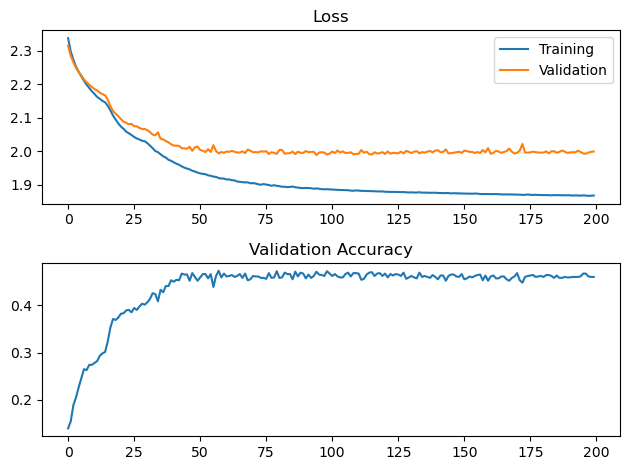

In [34]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(train_losses_fe, label='Training')
ax1.plot(valid_losses_fe, label='Validation')
ax1.legend()
ax1.set_title('Loss')
ax2.plot(valid_accuracies_fe)
ax2.set_title('Validation Accuracy')
plt.tight_layout()

In [35]:
model_f_f = GenreClassificationF(True).to(device)
model_f_f.load_state_dict(torch.load(saved_model_features))

# evaluate on the test data
test_loss, test_acc = evaluate(model_f_f, test_loader, criterion_features)
print(f'Test loss: {test_loss:.6f}')
print(f'Test accuracy: {100*test_acc:.2f}%')

Test loss: 2.004452
Test accuracy: 46.41%


## Case Study

Load Audio File/s

In [36]:
def extract_melspectrograms_case_study(audio_path, sample_rate=22050, win_duration=0.05, hop_duration=0.025, n_mels=64, segment_duration=3):
    segment_len = int(segment_duration * sample_rate)
    audio, original_rate = torchaudio.load(audio_path)
    num_segments = 10
    #print(audio.shape)
    audio = audio.mean(dim=0, keepdim=True)
    melspecgrams = []
    # extract Mel spectrogram for each segment
    for i in range(num_segments):
        start_idx = i * segment_len
        end_idx = start_idx + segment_len
        segment_audio = audio[:, start_idx:end_idx]
        
        # calculate spectrogram for the segment
        melspecgram = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate, n_fft=2048, win_length=round(win_duration * sample_rate),
            hop_length=round(hop_duration * sample_rate), n_mels=n_mels)(segment_audio).squeeze()
        
        melspecgrams.append(melspecgram)
    
    return melspecgrams

In [ ]:
#audio_paths_mp3 = [('./Jealousy_-_lillywolf_pop.mp3', 'pop.wav'), 
#                   ('./the_plan_-_stoneface_priest_-_stonefacepriest_reggae.mp3', 'reggae.wav'),
#                   ('./Ballyhoo_-_Barefoot_McCoy_country.mp3', 'country.wav'),
#                   ('./Antonio_Vivaldi__Four_Seasons_-_Excerpt_2_-_Marco_Tezza_classical.mp3', 'classical.wav'),
#                   ('./Uncle_Dave_-_boomboombeckett_jazz.mp3', 'jazz.wav')]
#
#for path, label in audio_paths_mp3:
#    
#    waveform, sample_rate = torchaudio.load(path)
#    output_path = label
#    torchaudio.save(output_path, waveform, 22050)

In [37]:
#import librosa
#import librosa.display

audio_paths_wav = [('./pop.wav', genres['pop']), 
                   ('./reggae.wav', genres['reggae']),
                   ('./country.wav', genres['country']),
                   ('./classical.wav', genres['classical']),
                   ('./jazz.wav', genres['jazz'])]

data_case_study = torch.zeros((50, 119, 64))  # for storing mel spectrograms of 3s long segments
labels_case_study = torch.zeros(50, 10)
counter = 0
for path, label in audio_paths_wav:
    print(path)
    print(label)
    mel_spectrograms = extract_melspectrograms_case_study(path, 22050, 0.05, 0.025, n_mels=64, segment_duration=3)
    for spectrogram in mel_spectrograms:
        #print(spectrogram.shape)
        if spectrogram.shape[1] < num_frames:
            spectrogram = nnF.pad(spectrogram, (0, num_frames - spectrogram.shape[1]))
        elif spectrogram.shape[1] > num_frames:
            spectrogram = spectrogram[:, :num_frames]
            
        data_case_study[counter] = spectrogram.T #[:num_frames]
        labels_case_study[counter] = torch.tensor(label, dtype=torch.float)
        counter += 1

    
data_case_study = torch.tensor(data_case_study)
labels_case_Study = torch.tensor(labels_case_study, dtype=torch.float)

dataset_case_study = TensorDataset(data_case_study, labels_case_study)

case_study_loader = DataLoader(dataset_case_study, batch_size=batch_size, shuffle=False)

./pop.wav
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
./reggae.wav
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
./country.wav
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
./classical.wav
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
./jazz.wav
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


/tmp/ipykernel_94/2203364240.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_case_study = torch.tensor(data_case_study)
/tmp/ipykernel_94/2203364240.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_case_Study = torch.tensor(labels_case_study, dtype=torch.float)


In [38]:
model_cs = GenreClassificationModel().to(device)
model_cs.load_state_dict(torch.load(saved_model))

#predictions = model_cs(data[])
#_, predicted_labels = torch.max(predictions, dim=1)
#print(predicted_labels)
# evaluate on the case_study data
case_study_loss, case_study_acc = evaluate(model_cs, case_study_loader, criterion)
print("Basic Model")
print(f'Case_Study loss: {case_study_loss:.6f}')
print(f'Case_Study accuracy: {100*case_study_acc:.2f}%')

Basic Model
Case_Study loss: 2.260438
Case_Study accuracy: 18.00%


In [39]:
model_cs2 = GenreClassificationF().to(device)
model_cs2.load_state_dict(torch.load(saved_model_f))

# evaluate on the case_study data
case_study_loss2, case_study_acc2 = evaluate(model_cs2, case_study_loader, criterion)
print("CRNN Model")
print(f'Case_Study loss: {case_study_loss2:.6f}')
print(f'Case_Study accuracy: {100*case_study_acc2:.2f}%')

CRNN Model
Case_Study loss: 2.183303
Case_Study accuracy: 34.00%


In [40]:
model_feature_estimation = FeatureEstimationModel()
predicitions = model_feature_estimation(data_case_study[:5])

print(predicitions)


tensor([[ 0.1704, -0.0987,  0.2248, -0.2246, -0.0342],
        [ 0.1995, -0.0351,  0.2163, -0.0887,  0.0749],
        [ 0.1930, -0.0414,  0.2473, -0.1269, -0.0069],
        [ 0.2862, -0.1872,  0.2392, -0.1668, -0.0186],
        [ 0.2493, -0.0846,  0.1110, -0.1558,  0.0768]], grad_fn=<EluBackward0>)


In [41]:
model_f_features = GenreClassificationF(True).to(device)
model_f_features.load_state_dict(torch.load(saved_model_features))

# evaluate on the case_study data
case_study_loss, case_study_acc = evaluate(model_f_features, case_study_loader, criterion_features)
print("CRNN Model with Feature Estimation")
print(f'Test loss: {case_study_loss:.6f}')
print(f'Test accuracy: {100*case_study_acc:.2f}%')

CRNN Model with Feature Estimation
Test loss: 2.231103
Test accuracy: 28.00%


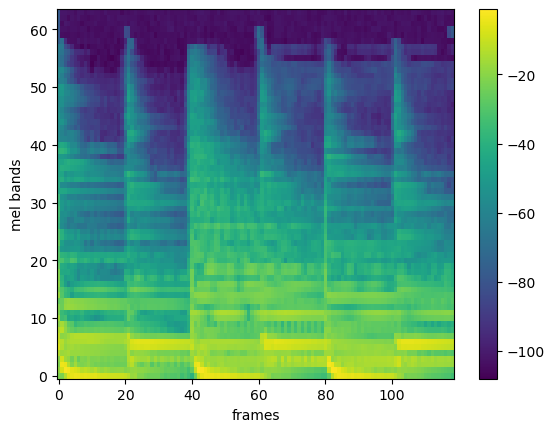

In [42]:
example_case_study = data_case_study[1]
dB_spec = taF.amplitude_to_DB(example_case_study, multiplier=10, amin=1e-8, db_multiplier=example.max().log10()).T
fig, ax = plt.subplots()
img = ax.imshow(dB_spec, aspect='auto', origin='lower')
fig.colorbar(img)
ax.set_xlabel('frames')
ax.set_ylabel('mel bands');